### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [1]:
import pandas as pd

Новости

In [2]:
# news = pd.read_csv("articles.csv")
news = pd.read_csv("/content/sample_data/articles.csv")

print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Пользователи

In [3]:
# users = pd.read_csv("users_articles.csv")
users = pd.read_csv("/content/sample_data/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Получаем векторные представления новостей

In [4]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
!pip install razdel

In [6]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 8.2 MB 33.8 MB/s 


In [7]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [8]:
import nltk
nltk.download('stopwords')
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
# with open('stopwords.txt') as f:
with open('/content/sample_data/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [10]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [11]:
%%time
# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


CPU times: user 23.1 s, sys: 1.2 s, total: 24.3 s
Wall time: 24.3 s


In [12]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 41s, sys: 623 ms, total: 3min 41s
Wall time: 3min 41s


А теперь в 3 строчки обучим нашу модель

In [13]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [14]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [15]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 41.7 s, sys: 19.3 s, total: 1min
Wall time: 39.1 s


In [16]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель

In [17]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(3, 0.20975357),
 (6, 0.05789488),
 (11, 0.14307183),
 (15, 0.2746022),
 (17, 0.12160133),
 (22, 0.1745396)]

In [18]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: век фестиваль ген мероприятие лаборатория фильм книга
topic_1: статья обнаружить рубль тыс налог ребёнок банк
topic_2: управление помощь агентство совет запуск россия nn
topic_3: наука система взрыв температура поверхность эксперимент всё
topic_4: российский россия вопрос проблема всё государство глава
topic_5: гражданин nn население район ребёнок пострадать журнал
topic_6: писать женщина мужчина иск nn городской снег
topic_7: доллар журнал животное пациент исследование северный клетка
topic_8: телескоп стоимость nn археолог необычный индия nthe
topic_9: ракета китай орбита проверка китайский пуск японский
topic_10: самолёт полёт спутник война нефть территория произойти
topic_11: украина отряд nn современный фрагмент русский гость
topic_12: исследователь nn путин заболевание болезнь nnn препарат
topic_13: область москва россия регион снижение объект строительство
topic_14: газ погибнуть украина пенсия египет жертва украинский
topic_15: кость звезда полоса хороший летний растен

Функция, которая будет возвращать векторное представление новости

In [19]:
# text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [20]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.058335,0.0,0.000000,0.000000,0.000000,0.914541,0.000000,0.000000,0.0,0.000000,0.000000,0.019729
1,4896,0.0,0.0,0.000000,0.976585,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,4897,0.0,0.0,0.000000,0.209734,0.000000,0.0,0.057910,0.0,0.0,0.0,0.0,0.143068,0.000000,0.000000,0.0,0.274627,0.000000,0.121625,0.000000,0.000000,0.000000,0.0,0.174499,0.000000,0.000000
3,4898,0.0,0.0,0.000000,0.243589,0.054683,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.051228,0.000000,0.000000,0.088696,0.040372,0.0,0.080566,0.432295,0.000000
4,4899,0.0,0.0,0.254458,0.000000,0.000000,0.0,0.330719,0.0,0.0,0.0,0.0,0.000000,0.233227,0.000000,0.0,0.056593,0.000000,0.000000,0.103382,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


### Следующий шаг - векторные представления пользователей

In [21]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [22]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [23]:
doc_dict[293622]

array([0.03952138, 0.        , 0.        , 0.03314599, 0.04496963,
       0.24539506, 0.        , 0.        , 0.        , 0.        ,
       0.0277661 , 0.07834636, 0.05108757, 0.        , 0.01269971,
       0.09336516, 0.        , 0.15564017, 0.        , 0.        ,
       0.19715084, 0.        , 0.        , 0.01532061, 0.        ])

# Задания 2, 3 в одной функции
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max

In [24]:
user_articles_list = users['articles'].iloc[33]

'''
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector
'''

def get_user_embedding(user_articles_list, func):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = func(user_vector, 0)
    return user_vector

In [25]:
get_user_embedding(user_articles_list, np.mean)

array([0.        , 0.0069905 , 0.11380441, 0.02615606, 0.1169644 ,
       0.04365564, 0.00215982, 0.04449932, 0.        , 0.01398826,
       0.05650703, 0.        , 0.0541483 , 0.08562598, 0.00194295,
       0.01073462, 0.00634325, 0.18880884, 0.06553726, 0.01097429,
       0.        , 0.00623173, 0.05712461, 0.07424605, 0.0023232 ])

In [26]:
get_user_embedding(user_articles_list, np.median)

array([0.        , 0.        , 0.04131399, 0.02171387, 0.11862939,
       0.00784383, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02425551, 0.00575122, 0.        ,
       0.        , 0.        , 0.13464824, 0.00926414, 0.        ,
       0.        , 0.        , 0.02671223, 0.        , 0.        ])

In [27]:
get_user_embedding(user_articles_list, np.max)

array([0.        , 0.04194302, 0.43594736, 0.07886153, 0.27216837,
       0.1898706 , 0.0129589 , 0.26699594, 0.        , 0.06229152,
       0.22435138, 0.        , 0.24085188, 0.41113228, 0.01165771,
       0.0644077 , 0.03805952, 0.43773758, 0.24333024, 0.03319292,
       0.        , 0.0373904 , 0.23535651, 0.26427352, 0.01393919])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [28]:
'''
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)
'''

"\nuser_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])\nuser_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]\nuser_embeddings['uid'] = users['uid'].values\nuser_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]\nuser_embeddings.head(3)\n"

In [29]:
# Оформим функцию для получения ембедингов для трех разных способов: mean, median, max
def user_emb(func):
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, func), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    return user_embeddings

In [30]:
user_embeddings_mean = user_emb(np.mean)
user_embeddings_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.039421,0.004016,0.058892,0.019831,0.059346,0.102464,0.038024,0.006081,0.019228,0.004957,0.038292,0.124141,0.040205,0.116246,0.041098,0.076709,0.021812,0.087759,0.006786,0.004048,0.039123,0.030638,0.000000,0.006797,0.000000
1,u108690,0.025265,0.043378,0.040027,0.022684,0.156532,0.039429,0.007351,0.005332,0.008540,0.000000,0.015232,0.038641,0.069077,0.046174,0.056634,0.000000,0.001794,0.186667,0.068459,0.065505,0.000000,0.032732,0.031780,0.023754,0.000000
2,u108339,0.007593,0.039758,0.143615,0.059629,0.061290,0.065871,0.009873,0.012610,0.002196,0.000000,0.057990,0.000000,0.009571,0.183143,0.038794,0.002984,0.023504,0.151393,0.065648,0.011034,0.000000,0.008441,0.004643,0.017616,0.002523


In [31]:
user_embeddings_median = user_emb(np.median)
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.019211,0.000000,0.000000,0.000000,0.062463,0.083474,0.006116,0.000000,0.0,0.0,0.013883,0.039173,0.008062,0.084000,0.021987,0.0,0.000000,0.082164,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1,u108690,0.019047,0.040969,0.042029,0.031835,0.118639,0.029660,0.000000,0.000000,0.0,0.0,0.012599,0.035306,0.043900,0.042802,0.015957,0.0,0.000000,0.142919,0.045980,0.048362,0.0,0.012242,0.006479,0.005994,0.0
2,u108339,0.000000,0.031015,0.027405,0.073695,0.044976,0.033856,0.000000,0.006843,0.0,0.0,0.048410,0.000000,0.005582,0.178195,0.021135,0.0,0.012558,0.185306,0.042435,0.000000,0.0,0.000000,0.000000,0.000000,0.0


In [32]:
user_embeddings_max = user_emb(np.max)
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.158585,0.024099,0.231491,0.085839,0.129769,0.245395,0.172964,0.036484,0.115369,0.029742,0.141870,0.431990,0.174020,0.299715,0.118070,0.366891,0.130870,0.206586,0.040716,0.024291,0.197151,0.100729,0.000000,0.025461,0.000000
1,u108690,0.063366,0.095483,0.089343,0.037623,0.326360,0.108170,0.044108,0.021958,0.051241,0.000000,0.033283,0.082822,0.184984,0.144627,0.195774,0.000000,0.010764,0.423366,0.190240,0.158945,0.000000,0.107925,0.099013,0.102403,0.000000
2,u108339,0.045560,0.111754,0.504475,0.116352,0.169540,0.171795,0.042933,0.042307,0.013179,0.000000,0.164468,0.000000,0.030960,0.314459,0.146295,0.017902,0.071884,0.260585,0.164487,0.046850,0.000000,0.033098,0.017059,0.089126,0.015136


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [33]:
# target = pd.read_csv("users_churn.csv")
target = pd.read_csv("/content/sample_data/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [34]:
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.039421,0.004016,0.058892,0.019831,0.059346,0.102464,0.038024,0.006081,0.019228,0.004957,0.038292,0.124141,0.040205,0.116246,0.041098,0.076709,0.021812,0.087759,0.006786,0.004048,0.039123,0.030638,0.000000,0.006797,0.000000,0
1,u108690,0.025265,0.043378,0.040027,0.022684,0.156532,0.039429,0.007351,0.005332,0.008540,0.000000,0.015232,0.038641,0.069077,0.046174,0.056634,0.000000,0.001794,0.186667,0.068459,0.065505,0.000000,0.032732,0.031780,0.023754,0.000000,1
2,u108339,0.007593,0.039758,0.143615,0.059629,0.061290,0.065871,0.009873,0.012610,0.002196,0.000000,0.057990,0.000000,0.009571,0.183143,0.038794,0.002984,0.023504,0.151393,0.065648,0.011034,0.000000,0.008441,0.004643,0.017616,0.002523,1


In [35]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.019211,0.000000,0.000000,0.000000,0.062463,0.083474,0.006116,0.000000,0.0,0.0,0.013883,0.039173,0.008062,0.084000,0.021987,0.0,0.000000,0.082164,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0
1,u108690,0.019047,0.040969,0.042029,0.031835,0.118639,0.029660,0.000000,0.000000,0.0,0.0,0.012599,0.035306,0.043900,0.042802,0.015957,0.0,0.000000,0.142919,0.045980,0.048362,0.0,0.012242,0.006479,0.005994,0.0,1
2,u108339,0.000000,0.031015,0.027405,0.073695,0.044976,0.033856,0.000000,0.006843,0.0,0.0,0.048410,0.000000,0.005582,0.178195,0.021135,0.0,0.012558,0.185306,0.042435,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1


In [36]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.158585,0.024099,0.231491,0.085839,0.129769,0.245395,0.172964,0.036484,0.115369,0.029742,0.141870,0.431990,0.174020,0.299715,0.118070,0.366891,0.130870,0.206586,0.040716,0.024291,0.197151,0.100729,0.000000,0.025461,0.000000,0
1,u108690,0.063366,0.095483,0.089343,0.037623,0.326360,0.108170,0.044108,0.021958,0.051241,0.000000,0.033283,0.082822,0.184984,0.144627,0.195774,0.000000,0.010764,0.423366,0.190240,0.158945,0.000000,0.107925,0.099013,0.102403,0.000000,1
2,u108339,0.045560,0.111754,0.504475,0.116352,0.169540,0.171795,0.042933,0.042307,0.013179,0.000000,0.164468,0.000000,0.030960,0.314459,0.146295,0.017902,0.071884,0.260585,0.164487,0.046850,0.000000,0.033098,0.017059,0.089126,0.015136,1


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [38]:

# X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    # X['churn'], random_state=0)

# разделим данные на train/test оформим так же в функцию
def splitter(X):
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]],
                                                        X['churn'],
                                                        random_state=0)
    return X_train, X_test, y_train, y_test

X_train_mean, X_test_mean, y_train_mean, y_test_mean = splitter(X_mean)
X_train_median, X_test_median, y_train_median, y_test_median = splitter(X_median)
X_train_max, X_test_max, y_train_max, y_test_max = splitter(X_max)

In [39]:
logreg_mean = LogisticRegression()
logreg_median = LogisticRegression()
logreg_max = LogisticRegression()
#обучим 
logreg_mean.fit(X_train_mean, y_train_mean)
logreg_median.fit(X_train_median, y_train_median)
logreg_max.fit(X_train_max, y_train_max)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
#наши прогнозы для тестовой выборки
predicts_mean = logreg_mean.predict_proba(X_test_mean)[:, 1]
predicts_median = logreg_median.predict_proba(X_test_median)[:, 1]
predicts_max = logreg_max.predict_proba(X_test_max)[:, 1]

In [41]:
predicts_mean[:10]

array([0.19191906, 0.0105566 , 0.31667324, 0.24478491, 0.13950204,
       0.06767388, 0.099634  , 0.01372219, 0.03000305, 0.10971787])

In [42]:
predicts_median[:10]

array([0.10840643, 0.01804151, 0.58173443, 0.17157837, 0.18876391,
       0.07429649, 0.10849739, 0.01096668, 0.04477409, 0.06300173])

In [43]:
predicts_max[:10]

array([5.17158956e-02, 6.32028456e-04, 8.99232641e-01, 2.34773716e-01,
       1.49015456e-01, 5.16534022e-03, 6.48531217e-02, 2.14147854e-02,
       6.79465498e-03, 1.37375926e-01])

In [44]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [45]:
import itertools

In [46]:
# оформим в функцию
def metrics(y_test, preds):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
    return precision, recall, thresholds, ix, fscore

In [47]:
precision_mean, recall_mean, thresholds_mean, ix_mean, fscore_mean = metrics(y_test_mean, predicts_mean)
precision_median, recall_median, thresholds_median, ix_median, fscore_median = metrics(y_test_median, predicts_median)
precision_max, recall_max, thresholds_max, ix_max, fscore_max = metrics(y_test_max, predicts_max)

Best Threshold=0.231994, F-Score=0.670, Precision=0.605, Recall=0.751
Best Threshold=0.266043, F-Score=0.837, Precision=0.815, Recall=0.861
Best Threshold=0.303545, F-Score=0.784, Precision=0.748, Recall=0.824


In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [49]:
def print_d(y_test, preds, thresholds, ix):
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                          title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()

Confusion matrix, without normalization
[[1635  120]
 [  62  183]]


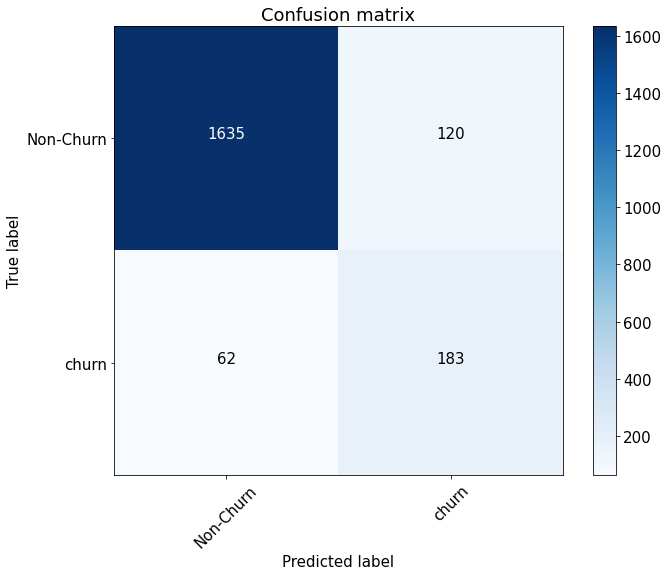

In [50]:
print_d(y_test_mean, predicts_mean, thresholds_mean, ix_mean)

Confusion matrix, without normalization
[[1707   48]
 [  35  210]]


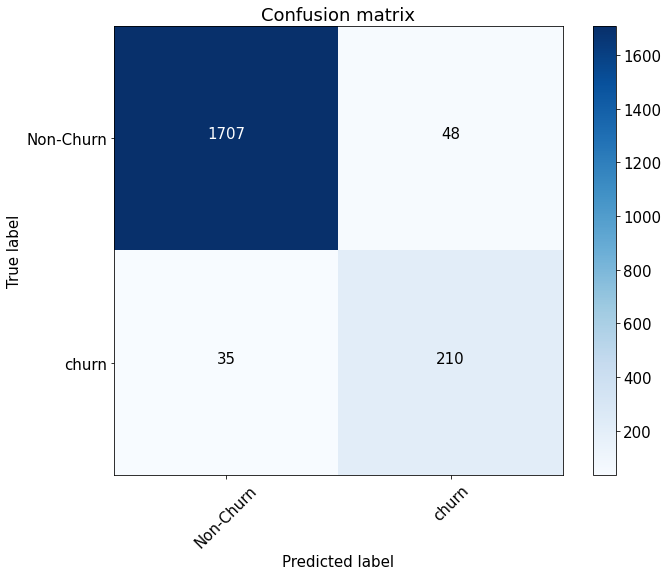

In [51]:
print_d(y_test_median, predicts_median, thresholds_median, ix_median)

Confusion matrix, without normalization
[[1687   68]
 [  44  201]]


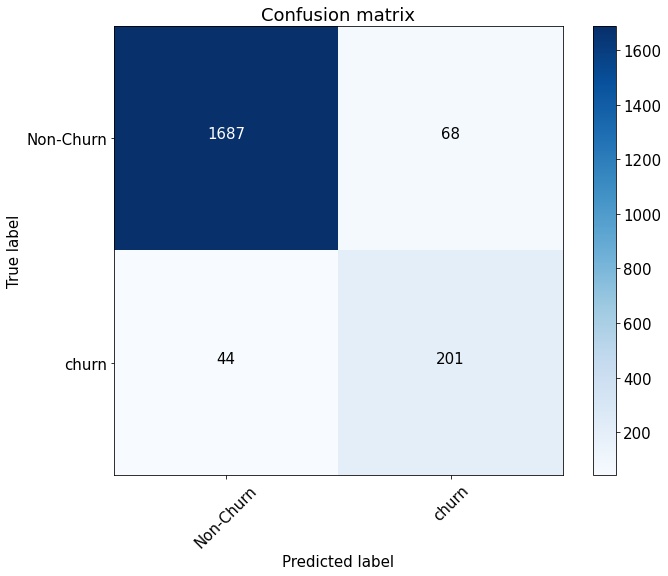

In [52]:
print_d(y_test_max, predicts_max, thresholds_max, ix_max)

In [53]:
roc_auc_score_mean = roc_auc_score(y_test_mean, predicts_mean)
roc_auc_score_mean

0.9410849467992325

In [54]:
roc_auc_score_median = roc_auc_score(y_test_median, predicts_median)
roc_auc_score_median

0.9823617652189082

In [55]:
roc_auc_score_max = roc_auc_score(y_test_max, predicts_max)
roc_auc_score_max

0.9773614745043315

### 5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [56]:
report = pd.DataFrame(
    {
        'Mean': [precision_mean[ix_mean], recall_mean[ix_mean], fscore_mean[ix_mean], roc_auc_score_mean],
        'Median': [precision_median[ix_median], recall_median[ix_median], fscore_median[ix_median], roc_auc_score_median],
        'Max': [precision_max[ix_max], recall_max[ix_max], fscore_max[ix_max], roc_auc_score_max]
    },
    index=['Precision', 'Recall', 'F1 score', 'Roc auc score']
)

report

,Mean,Median,Max
Precision,0.605263,0.814672,0.748148
Recall,0.751020,0.861224,0.824490
F1 score,0.670310,0.837302,0.784466
Roc auc score,0.941085,0.982362,0.977361


# 6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

На основе полученных данных видим, что mean имеет самую низкую метрику, max выше, median еще чуть выше median.

Здесь все объясеяется спецификой самих функций, которые используются в модели.

Так при расчете среднего значения модель будет улавливать только те значения, где имеется большое количество статей в тематике. В противном случае на фоне большого числа тем интерес будет как бы "размазан".

При расчете медианного значения, тут ситуация немного противоположная, фактически "выбросы" - где много статей одной тематики не будут иметь того большого влияния, т.к. медиана имеет свойство "отбрасывать" выбросы (хотя у нас это не выбросы на самом деле) и тем самым замечать более низкие значения.

В случае в с функцией max получается смесь и mean и median. С одной стороны взятие максимума позволяет замечать небольшие значения, а не "занулять" их, а с другой стороны большие значения оказывают большее влияние при обучении. 

